In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.stats.multitest as smm

from statannotations.Annotator import Annotator

# Load data

In [32]:
from analysis_utils import load_json_restore_arrays
data = load_json_restore_arrays('../data/data_electrophysiology.json')

#Keep only the cells with FS stimulation
data = data[data['FS_spikes'].notna()].reset_index(drop=True)

# Get FS responses

In [33]:
from analysis_utils import get_fs_response

In [34]:
# Initialize columns to hold lists
data['fs_tv'] = pd.Series([[] for _ in range(len(data))], index=data.index)
data['fs_response'] = pd.Series([[] for _ in range(len(data))], index=data.index)

fs_binw = 0.03
fs_range = [-1, 5]

# Loop through cells and calculate the FS response
for i, row in data.iterrows():
    spkt_fs = np.array(row['FS_spikes'])
    fs_onsets = np.array(row['FS_onset'])

    fs_tv, fs_response = get_fs_response(spkt_fs, fs_onsets, binw=fs_binw, trange=fs_range)

    data.at[i, 'fs_tv'] = fs_tv
    data.at[i, 'fs_response'] = fs_response


In [35]:
# get the foot shock response in a matrix format
psth_mat = np.vstack(np.array(data.fs_response))
psth_t = np.array(data.fs_tv[0])

# Compute parameters

Calculate FS modulation index

In [36]:
from analysis_utils import get_single_cell_fsmi

In [37]:
fs_modulation_index = []
for cnt in np.arange(len(data)):
    fs_modulation_index.append(get_single_cell_fsmi(psth_mat[cnt], psth_t, stim_tranges=[0, 0.5], ctype='modi', fr_crit=0))   

data['fs_modulation_index'] = fs_modulation_index

Calculate FR in ITI

In [38]:
from analysis_utils import get_fs_spkt
from analysis_utils import get_spikes_in_intertrial_interval

In [39]:
# Calculate spikes in intertrial interval
firing_rate_in_intertrial_interval = []
for idx in range(len(data)):
    trange = [1.5, 4.5]
    FS_spkt = get_fs_spkt(data, idx, trange=trange, split_by_trial=True)
    spikes_per_sec = get_spikes_in_intertrial_interval(FS_spkt, trange)
    firing_rate_in_intertrial_interval.append(spikes_per_sec)
data['firing_rate_in_intertrial_interval'] = firing_rate_in_intertrial_interval

Calculate FS reliability

In [40]:
cellIDs = data['Cell_Num'].values
reliability_window = .1
reliabilities = []
fs_responsive_trials_num = []
fs_trials_num = []
for i in range(data.shape[0]):

    cellID = cellIDs[i]
    cell_idx = data[data['Cell_Num'] == cellID].index[0]

    spkt = data.at[cell_idx, 'FS_spikes']
    fs_onsets = np.array(data.at[cell_idx, 'FS_onset'])
    
    # Set time windows where to check for spikes
    reliability_ranges = np.array([fs_onsets, (fs_onsets+reliability_window)]).T
    
    # Loop over trials
    trial_ids_w_spike = []
    for trial_id in range(fs_onsets.shape[0]):
        if sum((spkt>reliability_ranges[trial_id,0]) & (spkt<reliability_ranges[trial_id,1])) > 0:
            trial_ids_w_spike.append(trial_id)
    reliabilities.append(len(trial_ids_w_spike)/fs_onsets.shape[0])
    fs_responsive_trials_num.append(len(trial_ids_w_spike))
    fs_trials_num.append(fs_onsets.shape[0])


data['fs_reliability'] = reliabilities
data['fs_responsive_trials_num'] = fs_responsive_trials_num
data['fs_trials_num'] = fs_trials_num

Calculate silencing index

In [41]:
data['firing_rate_ratio'] = data['firing_rate_in_intertrial_interval']/data['firing_rate']
data[['Cell_Num', 'TH_label', 'firing_rate', 'firing_rate_in_intertrial_interval', 'firing_rate_ratio']]

postactivation_firing_supression_index = (data['firing_rate_in_intertrial_interval'] - data['firing_rate']) / (data['firing_rate_in_intertrial_interval'] + data['firing_rate'])
data['postactivation_firing_supression_index'] = postactivation_firing_supression_index

Calculate latencies

In [42]:
from analysis_utils import calculate_latencies

data['latencies_ms'] = data.apply(calculate_latencies, axis=1)
data['fs_median_latency_ms'] = data['latencies_ms'].apply(lambda x: np.nanmedian(x))

In [43]:
response_ratio = []
for cnt in np.arange(len(data)):
    response_ratio.append(psth_mat[cnt].max() / np.mean(psth_mat[cnt][np.where(psth_t<0)]))
    
data['fs_response_ratio'] = response_ratio

# Statistics

Calculate statistics on the activation

In [44]:
# Define the list of features to test
features_activation = ['fs_modulation_index', 'fs_response_ratio', 'fs_reliability', 'fs_median_latency_ms']  # Features of the activation

p_values_activation = {}
# Loop over the list of features and calculate the p-value for each feature
for feature in features_activation:
    x1 = np.array(data[data['TH_label'] == 'pos'][feature].dropna().to_numpy(), dtype=float)
    x2 = np.array(data[data['TH_label'] == 'neg'][feature].dropna().to_numpy(), dtype=float)
    
    stats, p = scipy.stats.mannwhitneyu(x=x1, y=x2)
    p = np.round(p, 3) 
    p_values_activation[feature] = '{}'.format(p)  

# Print the results
for i, feature in enumerate(features_activation):
    
    formatted_pval = p_values_activation.get(feature)
    
    # Recalculate x1 and x2 to get counts
    x1 = data[data['TH_label'] == 'pos'][feature].dropna().to_numpy()
    x2 = data[data['TH_label'] == 'neg'][feature].dropna().to_numpy()
    
    # Calculate mean and standard deviation for pos and neg
    mean_x1 = np.round(np.mean(x1), 2)
    std_x1 = np.round(np.std(x1, ddof=1), 2)
    mean_x2 = np.round(np.mean(x2), 2)
    std_x2 = np.round(np.std(x2, ddof=1), 2)
    
    print(f'Feature: {feature}')
    print('N_pos =', len(x1))
    print('N_neg =', len(x2))
    print('Mean±std (pos): {} ± {}'.format(mean_x1, std_x1))
    print('Mean±std (neg): {} ± {}'.format(mean_x2, std_x2))
    print('P-value:', formatted_pval)
    print('---')

Feature: fs_modulation_index
N_pos = 14
N_neg = 9
Mean±std (pos): 0.9 ± 0.07
Mean±std (neg): 0.71 ± 0.2
P-value: 0.009
---
Feature: fs_response_ratio
N_pos = 14
N_neg = 9
Mean±std (pos): 89.38 ± 61.27
Mean±std (neg): 44.27 ± 44.87
P-value: 0.021
---
Feature: fs_reliability
N_pos = 14
N_neg = 9
Mean±std (pos): 0.74 ± 0.25
Mean±std (neg): 0.8 ± 0.2
P-value: 0.899
---
Feature: fs_median_latency_ms
N_pos = 14
N_neg = 9
Mean±std (pos): 51.83 ± 13.6
Mean±std (neg): 47.21 ± 16.79
P-value: 0.469
---


Calculate statistics on the post-activation suppression

In [45]:
features_supression = ['firing_rate_in_intertrial_interval', 'postactivation_firing_supression_index']  # Features of the post-activation suppression

# Loop over the list of features and calculate the p-value for each feature
p_values_supression = {}
for feature in features_supression:
    
    x1 = np.array(data[data['TH_label'] == 'pos'][feature].dropna().to_numpy(), dtype=float)
    x2 = np.array(data[data['TH_label'] == 'neg'][feature].dropna().to_numpy(), dtype=float)
    
    stats, p = scipy.stats.mannwhitneyu(x=x1, y=x2)
    p = np.round(p, 3) 
    p_values_supression[feature] = '{}'.format(p)  

# Print the results
for i, feature in enumerate(features_supression):
    
    formatted_pval = p_values_supression.get(feature)
    
    # Recalculate x1 and x2 to get counts
    x1 = data[data['TH_label'] == 'pos'][feature].dropna().to_numpy()
    x2 = data[data['TH_label'] == 'neg'][feature].dropna().to_numpy()
    
    # Calculate mean and standard deviation for pos and neg
    mean_x1 = np.round(np.mean(x1), 2)
    std_x1 = np.round(np.std(x1, ddof=1), 2)
    mean_x2 = np.round(np.mean(x2), 2)
    std_x2 = np.round(np.std(x2, ddof=1), 2)
    
    print(f'Feature: {feature}')
    print('N_pos =', len(x1))
    print('N_neg =', len(x2))
    print('Mean±std (pos): {} ± {}'.format(mean_x1, std_x1))
    print('Mean±std (neg): {} ± {}'.format(mean_x2, std_x2))
    print('P-value:', formatted_pval)
    print('---')

Feature: firing_rate_in_intertrial_interval
N_pos = 14
N_neg = 9
Mean±std (pos): 0.14 ± 0.13
Mean±std (neg): 0.69 ± 0.51
P-value: 0.013
---
Feature: postactivation_firing_supression_index
N_pos = 14
N_neg = 9
Mean±std (pos): -0.63 ± 0.34
Mean±std (neg): -0.18 ± 0.5
P-value: 0.015
---


# Plotting

In [46]:
# Plotting parameters
colors = dict(pos='#7570b3', neg='#1b9e77')
plt.rcParams['svg.fonttype'] = 'none'

In [47]:
df_pos = data[data['TH_label']=='pos']
df_neg = data[data['TH_label']=='neg']

## Plot activation metrics

Reliability

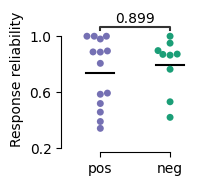

In [48]:
feature = 'fs_reliability'
formatted_pvals_plot = [p_values_activation.get(feature)]

fig, ax = plt.subplots(1,1,figsize=(1.8, 1.8))

sns.swarmplot(data=data,
             x='TH_label',
             y=feature,
             palette=colors,
             ax=ax)
ax.plot([-.2, .2], [np.mean(df_pos[feature].values), np.mean(df_pos[feature].values)], color='k')
ax.plot([.8, 1.2], [np.mean(df_neg[feature].values), np.mean(df_neg[feature].values)], color='k')

ax.set_xlabel('')
#ax.set_xticklabels(['TH-pos', 'TH-neg'], fontsize=8)
ax.set_ylabel('Response reliability', fontsize=10)
ax.set_yticks([0.2, 0.6, 1])
ax.set_ylim([0.2, 1])

# Stats annotations
annotator = Annotator(data=data,
                      x='TH_label',
                      y=feature,
                      pairs=[('pos','neg')],
                      order=None, 
                      orient='v',
                      short_test_name=False,
                      ax=ax,
                      verbose=False
                      )
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
annotator.configure(loc='outside', fontsize=8, line_width=1)
    
sns.despine(offset=3,trim=True)

fig.patch.set_facecolor('white')
#fig.savefig('../plots/footshock_reliability.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/footshock_reliability.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

Plot Foot shock modulation index

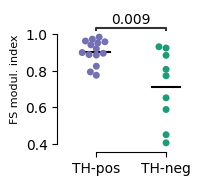

In [49]:
feature = 'fs_modulation_index'
formatted_pvals_plot = [p_values_activation.get(feature)]

fig, ax = plt.subplots(1,1,figsize=(1.8, 1.8))

sns.swarmplot(data=data,
             x='TH_label',
             y=feature,
             palette=colors,
             ax=ax)

ax.plot([-.2, .2], [np.mean(df_pos[feature].values), np.mean(df_pos[feature].values)], color='k')
ax.plot([.8, 1.2], [np.mean(df_neg[feature].values), np.mean(df_neg[feature].values)], color='k')

ax.set_xlabel('')
ax.set_xticklabels(['TH-pos', 'TH-neg'], fontsize=8)
ax.set_ylabel('FS modul. index', fontsize=8)

# Stats annotations
annotator = Annotator(data=data,
                      x='TH_label',
                      y=feature,
                      pairs=[('pos','neg')],
                      order=None, 
                      orient='v',
                      short_test_name=False,
                      ax=ax,
                      verbose=False
                      )
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
annotator.configure(loc='outside', fontsize=8, line_width=1)
    
sns.despine(offset=3,trim=True)

fig.patch.set_facecolor('white')
#fig.savefig('../plots/footshock_modulation_index.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/footshock_modulation_index.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

## Plot post-activation inhibition metrics

Firing rate in intertrial interval

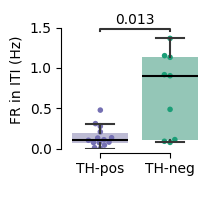

In [50]:
feature = 'firing_rate_in_intertrial_interval'
formatted_pvals_plot = [p_values_supression.get(feature)]

feature_name = 'Firing Rate in ITI'

fig, ax = plt.subplots(figsize=(1.8, 1.8))
    
sns.boxplot(showmeans=False,
            meanline=False,
            medianprops={'visible':True, 'color': 'black'},
            whiskerprops={'visible': True},
            zorder=10,
            x="TH_label",
            order=['pos', 'neg'],
            y=feature,
            data=data,
            showfliers=False,
            showbox=True,
            showcaps=True,
            palette=colors,
            boxprops=dict(alpha=.5, edgecolor='none'),
            ax=ax
            )

sns.swarmplot(data=data, y=feature, x='TH_label', ax=ax, palette=colors, size=4)
ax.set_ylabel('FR in ITI (Hz)')
ax.set_xlabel(' ')
ax.set_xticklabels(['TH-pos', 'TH-neg'])
ax.set_ylim(0, 1.5)
ax.set_yticks([0, .5, 1, 1.5])
    
# Add significance bars
annotator = Annotator(ax=ax, 
                      data=data,
                      x='TH_label',
                      y=feature, 
                      pairs=[('pos', 'neg')],
                      order=None,
                      verbose=False)
    
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
annotator.configure(loc='outside', fontsize=8, line_width=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sns.despine(offset=3,trim=True)
    
fig.patch.set_facecolor('white')

#fig.savefig('../plots/footshock_firing_rate_in_ITI.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False, dpi=300)
#fig.savefig('../plots/footshock_firing_rate_in_ITI.png', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False, dpi=300)
plt.show()

Footshock silencing index

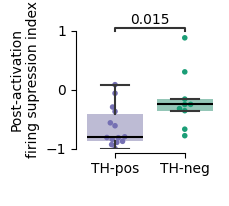

In [51]:
feature = 'postactivation_firing_supression_index'
formatted_pvals_plot = [p_values_supression.get(feature)]

feature_name = 'Post-activation\nfiring supression index'

fig, ax = plt.subplots(figsize=(1.8, 1.8))
    
sns.boxplot(showmeans=False,
            meanline=False,
            medianprops={'visible':True, 'color': 'black'},
            whiskerprops={'visible': True},
            zorder=10,
            x="TH_label",
            order=['pos', 'neg'],
            y=feature,
            data=data,
            showfliers=False,
            showbox=True,
            showcaps=True,
            palette=colors,
            boxprops=dict(alpha=.5, edgecolor='none'),
            ax=ax)

sns.swarmplot(data=data, y=feature, x='TH_label', ax=ax, palette=colors, size=4)
ax.set_ylabel(feature_name)
ax.set_xlabel(' ')
ax.set_xticklabels(['TH-pos', 'TH-neg'])
ax.set_ylim(-1, 1)
ax.set_yticks([-1, 0, 1])
    
# Add significance bar
annotator = Annotator(ax=ax, 
                      data=data,
                      x='TH_label',
                      y=feature, 
                      pairs=[('pos', 'neg')],
                      order=None,
                      verbose=False)
    
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
annotator.configure(loc='outside', fontsize=8, line_width=1)

sns.despine(offset=3,trim=True)

fig.patch.set_facecolor('white')

#fig.savefig('../plots/footshock_postactivation_firing_supression_index.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False, dpi=300)
#fig.savefig('../plots/footshock_postactivation_firing_supression_index.png', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False, dpi=300)

plt.show()

## Footshock raster and PSTH plots for all cells

In [52]:
# Sort data for plotting
data.sort_values(by=['TH_label', 'Cell_Num'], ascending=[False, True], inplace=True)
data.reset_index(drop=True, inplace=True)

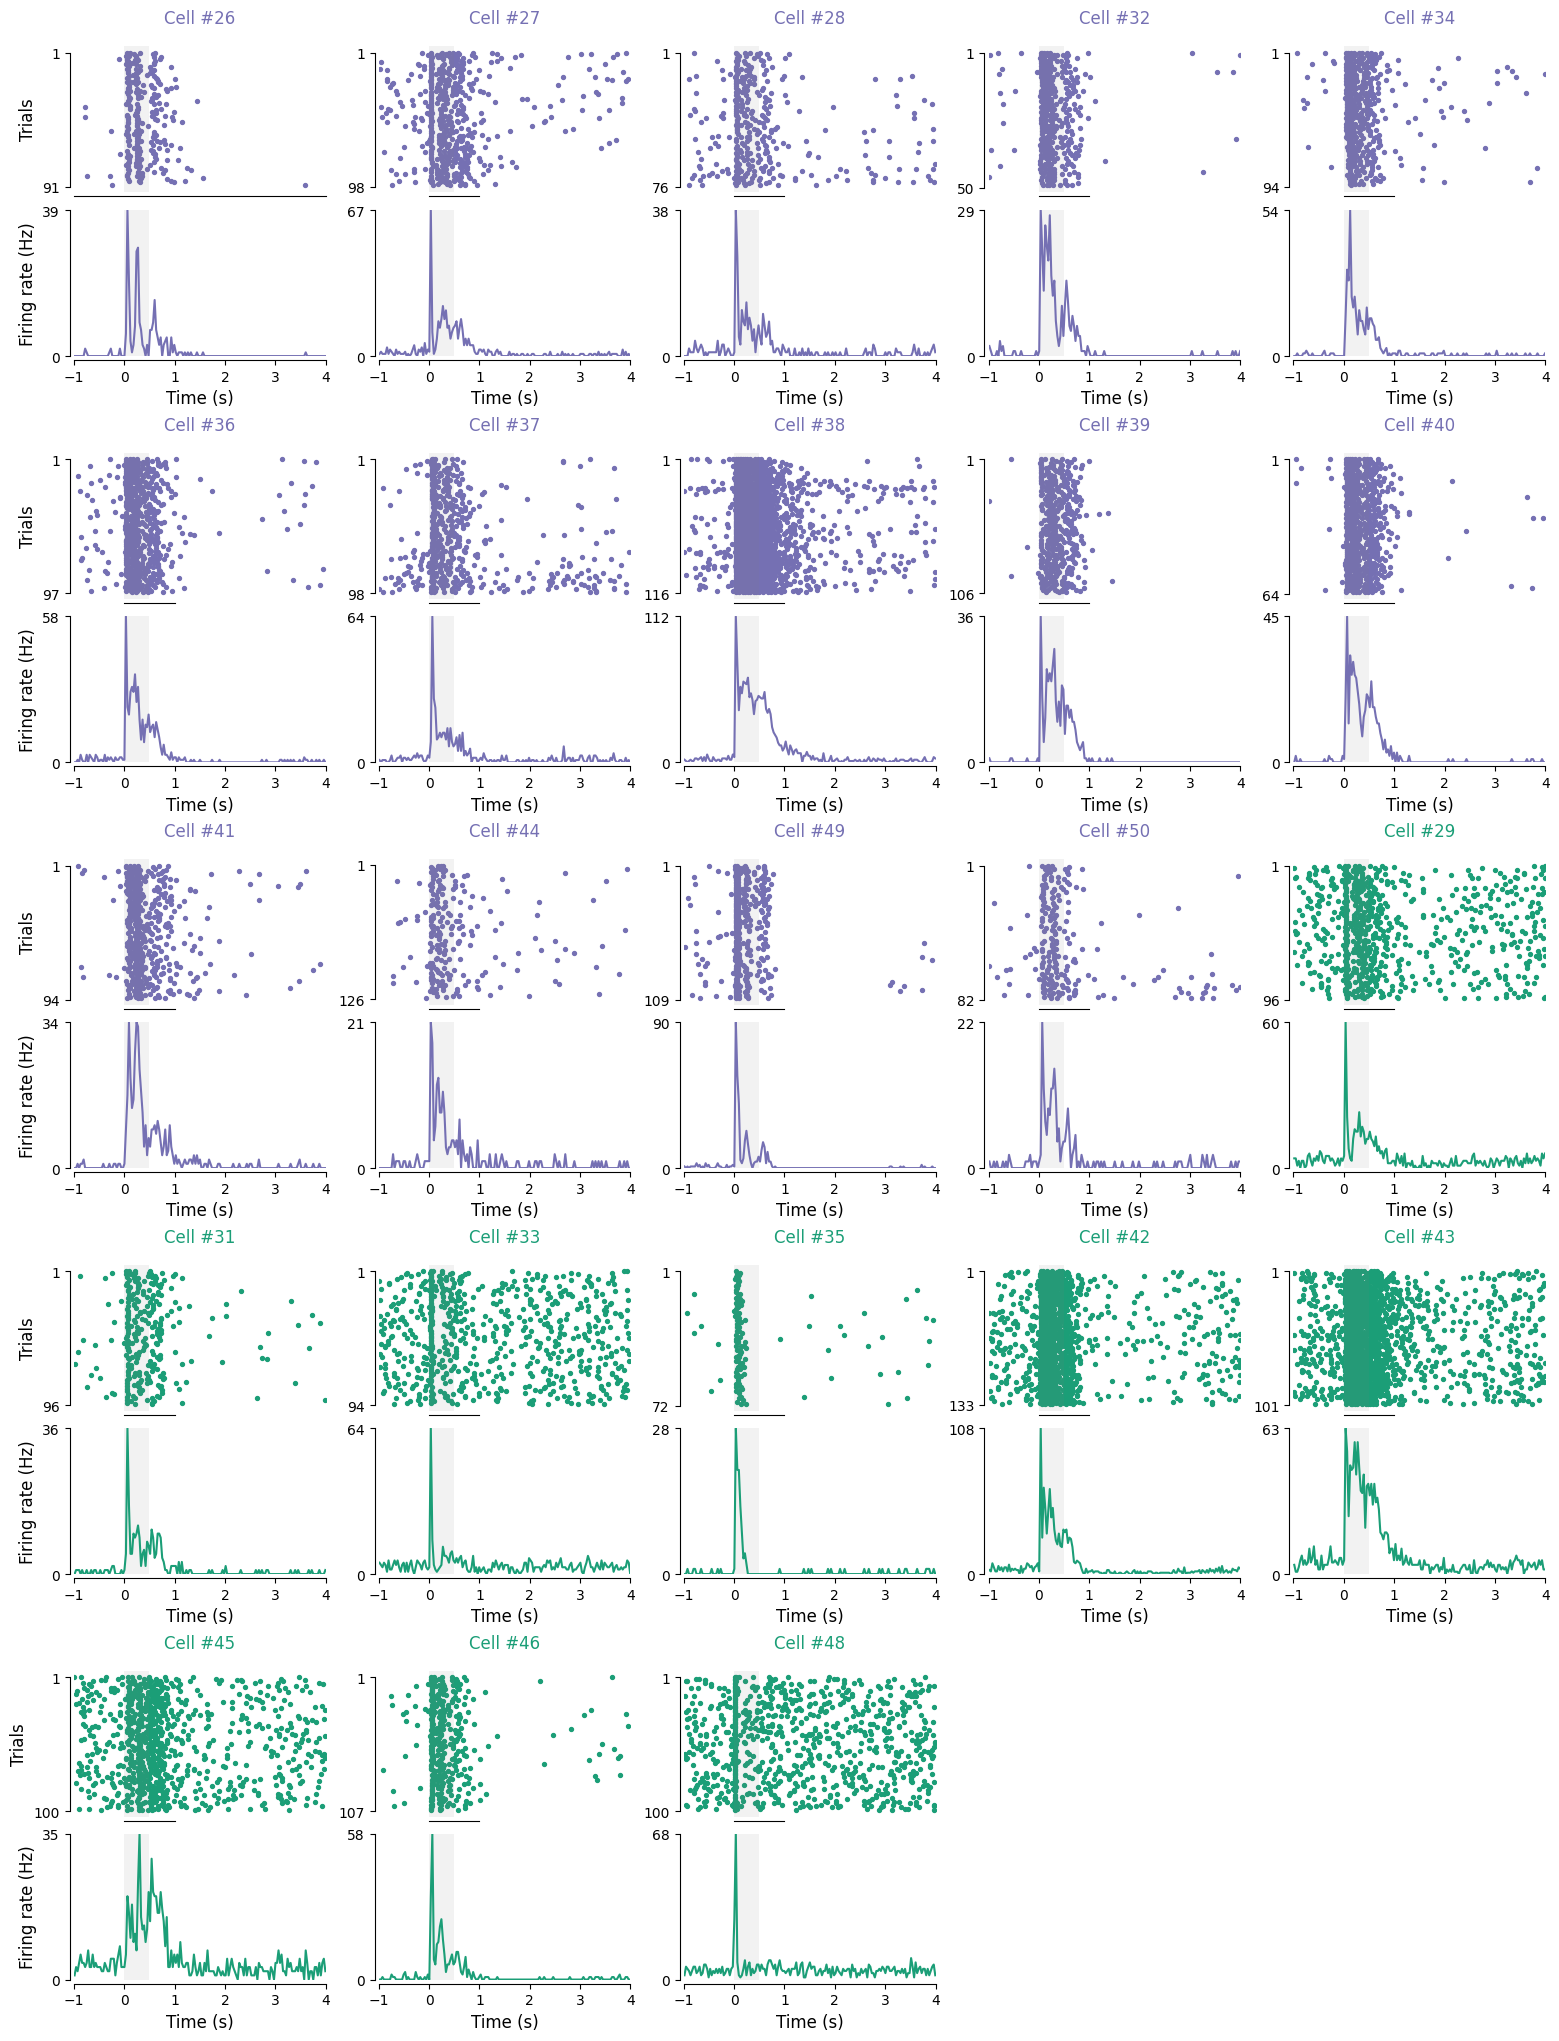

In [53]:
df=data
trange=[-1, 4]
marker='o'
s=8
alpha=1
ev_trange=[0, 0.5]
binw=0.03

fig, axs = plt.subplots(12,5,figsize=(15.48, 23.22), constrained_layout=True)

rows = np.arange(0,12,2)
columns = np.arange(0,5,1)
idx=0

for row in rows:
    for column in columns:
        if idx < len(data.Cell_Num):
                       
            # Get data
            cellID = data.Cell_Num[idx]
            cell_idx = data[data['Cell_Num'] == cellID].index[0]

            # Get spike times and stimulus onsets
            spkt = np.array(data.at[cell_idx, 'FS_spikes'])
            fs_onsets = data.at[cell_idx, 'FS_onset']
            TH_label = data.at[cell_idx,'TH_label']
            
            # Loop through trials and get spkt
            FS_spkt = []
            y = []
            t_prev_fs = trange[0]
            t_aft_fs = trange[1]
            for i, fs_onset in enumerate(fs_onsets):
                # Save spike times for the respective trial
                t_start = fs_onset + t_prev_fs
                t_stop = fs_onset + t_aft_fs
                spkt_fs_raw = spkt[((spkt >= t_start) & (spkt <= t_stop))]
                FS_spkt.append(spkt_fs_raw - fs_onset)
                # Save trial number
                num_spikes = spkt_fs_raw.shape[0]
                y.append(np.ones(num_spikes, ) * i)

            bin_edges = np.arange(trange[0], trange[1] + binw, binw)
            psth, bins = np.histogram(np.sort(np.hstack(FS_spkt)), bins=bin_edges)
            bincenters = bins[:-1] + binw / 2

            # Plotting
            if TH_label=='pos':
                color = colors['pos']
            else:
                color = colors['neg']
            
            # Scatter
            ax = axs[row,column]
            for i in range(len(FS_spkt)):
                ax.scatter(FS_spkt[i], y[i], color=color, marker=marker, s=s, alpha=alpha)
            ax.invert_yaxis()
            ax.set_xlim((t_prev_fs, t_aft_fs))
            ax.axvspan(xmin=ev_trange[0], xmax=ev_trange[1], facecolor='gray', alpha=0.1)
            ax.set_title('Cell #{:s}'.format(data[data['Cell_Num'] == cellID]['Cell_Num'].to_string(index=False)), y=1.1, color=color, fontsize=12)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.spines['bottom'].set_visible(False)
            ax.set_yticks([0, len(FS_spkt)])
            ax.set_yticklabels([1, len(FS_spkt)], fontsize=12)
            if column == 0:
                ax.set_ylabel('Trials', fontsize=12)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
 
            # PSTH
            ax = axs[row+1,column]
            ax.plot(bincenters, psth, color=color)
            ax.axvspan(xmin=ev_trange[0], xmax=ev_trange[1], facecolor='gray', alpha=0.1)
            ax.set_xlabel('Time (s)', fontsize=12)
            ax.set_xlim((t_prev_fs, t_aft_fs))
            if column == 0:
                ax.set_ylabel('Firing rate (Hz)', fontsize=12)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_xticks(np.arange(-1,5,1))
            ax.set_ylim(0, np.max(psth))
            ax.set_yticks([0, np.max(psth)])
            
        else:
            fig.delaxes(axs[row,column])
            fig.delaxes(axs[row+1,column])

        idx = idx+1
        
        sns.despine(offset=3,trim=True)
        
fig.patch.set_facecolor('white')

#fig.savefig('../plots/footshock_raster_PSTH.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/footshock_raster_PSTH.svg', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

plt.show()

Figure 1N: raster plot and PSTH negative example

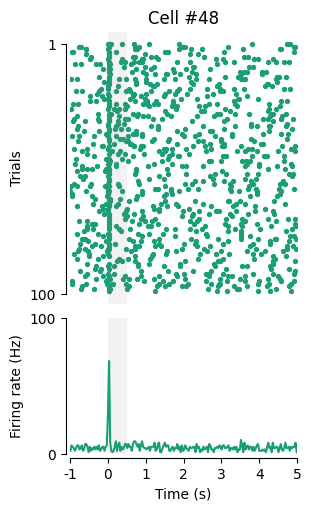

In [54]:
trange = [-1, 5]
marker = 'o'
s = 8
alpha = 1
ev_trange = [0, 0.5]
binw = 0.03

fig, axs = plt.subplots(2, 1, figsize=(3, 5), constrained_layout=True, gridspec_kw={'height_ratios': [2, 1]})

idx = data[data['Cell_Num'] == 48].index[0]  # First neuron index
cellID = data['Cell_Num'][idx]
cell_idx = data[data['Cell_Num'] == cellID].index[0]

spkt = np.array(data.at[cell_idx, 'FS_spikes'])
fs_onsets = data.at[cell_idx, 'FS_onset']
TH_label = data.at[cell_idx, 'TH_label']

FS_spkt = []
y = []
for i, fs_onset in enumerate(fs_onsets):
    t_start = fs_onset + trange[0]
    t_stop = fs_onset + trange[1]
    spkt_fs_raw = spkt[((spkt >= t_start) & (spkt <= t_stop))]
    FS_spkt.append(spkt_fs_raw - fs_onset)
    num_spikes = spkt_fs_raw.shape[0]
    y.append(np.ones(num_spikes, ) * i)

bin_edges = np.arange(trange[0], trange[1] + binw, binw)
psth, bins = np.histogram(np.hstack(FS_spkt), bins=bin_edges)
bincenters = bins[:-1] + binw / 2

color = colors['pos'] if TH_label == 'pos' else colors['neg']

# Raster
ax_raster = axs[0]
for i in range(len(FS_spkt)):
    ax_raster.scatter(FS_spkt[i], y[i], color=color, marker=marker, s=s, alpha=alpha)
ax_raster.invert_yaxis()
ax_raster.set_xlim(trange)
ax_raster.axvspan(xmin=ev_trange[0], xmax=ev_trange[1], facecolor='gray', alpha=0.1)
ax_raster.set_title(f'Cell #{cellID}')
ax_raster.set_ylabel('Trials')
ax_raster.set_xticks([])  # Remove x-axis labels for the raster plot
ax_raster.set_yticks([0, len(FS_spkt)])
ax_raster.set_yticklabels([1, len(FS_spkt)])
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)
ax_raster.spines['bottom'].set_visible(False)

# PSTH
ax_psth = axs[1] 
ax_psth.plot(bincenters, psth, color=color)
ax_psth.axvspan(xmin=ev_trange[0], xmax=ev_trange[1], facecolor='gray', alpha=0.1)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylabel('Firing rate (Hz)')
ax_psth.set_xlim(trange)
ax_psth.set_xticks(np.arange(trange[0], trange[1]+1, 1))
ax_psth.set_ylim(0, 100)
ax_psth.set_yticks([0, 100])
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)
ax_psth.set_xlim(-1, 5)
ax_psth.set_xticks([-1, 0, 1, 2, 3, 4, 5])
ax_psth.set_xticklabels([-1, 0, 1, 2, 3, 4, 5])
sns.despine(ax=ax_raster, offset=3, trim=True)
sns.despine(ax=ax_psth, offset=3, trim=True)

ax_raster.spines['bottom'].set_visible(False)

fig.patch.set_facecolor('white')
plt.show()

#fig.savefig('../plots/footshock_raster_PSTH_neg.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/footshock_raster_PSTH_neg.svg', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)


Figure 1H: raster plot and PSTH positive example

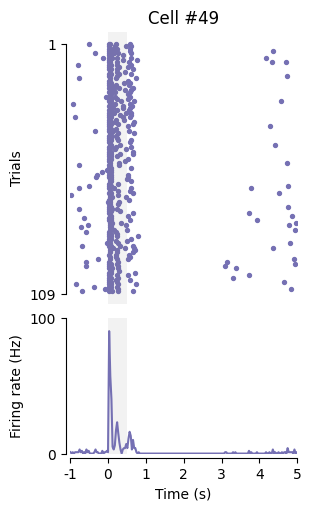

In [55]:
trange = [-1, 5]
marker = 'o'
s = 8
alpha = 1
ev_trange = [0, 0.5]
binw = 0.03

fig, axs = plt.subplots(2, 1, figsize=(3, 5), constrained_layout=True, gridspec_kw={'height_ratios': [2, 1]})

idx = data[data['Cell_Num'] == 49].index[0]  # First neuron index
cellID = data['Cell_Num'][idx]
cell_idx = data[data['Cell_Num'] == cellID].index[0]

spkt = np.array(data.at[cell_idx, 'FS_spikes'])
fs_onsets = data.at[cell_idx, 'FS_onset']
TH_label = data.at[cell_idx, 'TH_label']

FS_spkt = []
y = []
for i, fs_onset in enumerate(fs_onsets):
    t_start = fs_onset + trange[0]
    t_stop = fs_onset + trange[1]
    spkt_fs_raw = spkt[((spkt >= t_start) & (spkt <= t_stop))]
    FS_spkt.append(spkt_fs_raw - fs_onset)
    num_spikes = spkt_fs_raw.shape[0]
    y.append(np.ones(num_spikes, ) * i)

bin_edges = np.arange(trange[0], trange[1] + binw, binw)
psth, bins = np.histogram(np.hstack(FS_spkt), bins=bin_edges)
bincenters = bins[:-1] + binw / 2

color = colors['pos'] if TH_label == 'pos' else colors['neg']

# Raster
ax_raster = axs[0]
for i in range(len(FS_spkt)):
    ax_raster.scatter(FS_spkt[i], y[i], color=color, marker=marker, s=s, alpha=alpha)
ax_raster.invert_yaxis()
ax_raster.set_xlim(trange)
ax_raster.axvspan(xmin=ev_trange[0], xmax=ev_trange[1], facecolor='gray', alpha=0.1)
ax_raster.set_title(f'Cell #{cellID}')
ax_raster.set_ylabel('Trials')
ax_raster.set_xticks([])
ax_raster.set_yticks([0, len(FS_spkt)])
ax_raster.set_yticklabels([1, len(FS_spkt)])
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)
ax_raster.spines['bottom'].set_visible(False)

# PSTH
ax_psth = axs[1] 
ax_psth.plot(bincenters, psth, color=color)
ax_psth.axvspan(xmin=ev_trange[0], xmax=ev_trange[1], facecolor='gray', alpha=0.1)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylabel('Firing rate (Hz)')
ax_psth.set_xlim(trange)
ax_psth.set_xticks(np.arange(trange[0], trange[1]+1, 1))
ax_psth.set_ylim(0, 100)
ax_psth.set_yticks([0, 100])
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)
ax_psth.set_xlim(-1, 5)
ax_psth.set_xticks([-1, 0, 1, 2, 3, 4, 5])
ax_psth.set_xticklabels([-1, 0, 1, 2, 3, 4, 5])
sns.despine(ax=ax_raster, offset=3, trim=True)
sns.despine(ax=ax_psth, offset=3, trim=True)

ax_raster.spines['bottom'].set_visible(False)

fig.patch.set_facecolor('white')
plt.show()

#fig.savefig('../plots/footshock_raster_PSTH_pos.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/footshock_raster_PSTH_pos.svg', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)


# Figure 3A-B: Footshock heatmap and mean responses 

In [56]:
from analysis_utils import get_fs_psth_mat

In [57]:
# Calculate the footshock response for all cells
df_pos = data[data['TH_label']=='pos'].dropna()
df_neg = data[data['TH_label']=='neg'].dropna()

footshock_response_bin_width = 0.02
footshock_response_time_range = [-1, 2]

fs_resp_pos, cell_ids_pos, FS_resp_tv = get_fs_psth_mat(df_pos, exclude_nans=True, norm_per_cell=False, standardize_per_cell=True, set_baseline=True, verbal=True, binw=footshock_response_bin_width, trange=footshock_response_time_range)
idx_pos_sort = np.argsort(np.max(fs_resp_pos, axis=1))
fs_resp_pos_sorted = fs_resp_pos[idx_pos_sort[::-1]]

fs_resp_neg, cell_ids_neg, FS_resp_tv = get_fs_psth_mat(df_neg, exclude_nans=True, norm_per_cell=False, standardize_per_cell=True, set_baseline=True, verbal=True, binw=footshock_response_bin_width, trange=footshock_response_time_range)
idx_neg_sort = np.argsort(np.max(fs_resp_neg, axis=1))
fs_resp_neg_sorted = fs_resp_neg[idx_neg_sort[::-1]]

fs_resp_pos_mean = np.mean(fs_resp_pos, axis=0)
fs_resp_neg_mean = np.mean(fs_resp_neg, axis=0)
fs_resp_pos_std = np.std(fs_resp_pos, axis=0)
fs_resp_neg_std = np.std(fs_resp_neg, axis=0)

0/14 cells without FS-response.
0/9 cells without FS-response.


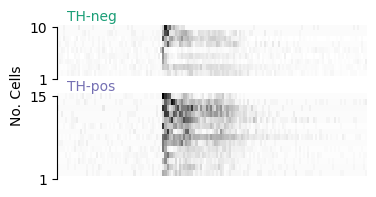

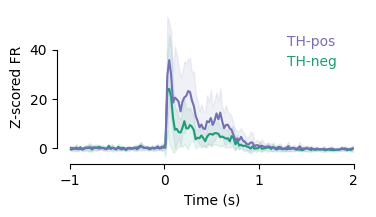

In [58]:
# Plot heatmap

vmin = np.min([np.min(fs_resp_pos), np.min(fs_resp_neg)])
vmax = np.max([np.max(fs_resp_pos), np.max(fs_resp_neg)])

fig, axs = plt.subplots(2,1,figsize=(4,2),
                       gridspec_kw={'height_ratios': [df_neg.shape[0], df_pos.shape[0]]})

axs[0].imshow(fs_resp_neg_sorted, interpolation='none', aspect='auto', cmap='gray_r', vmin=vmin, vmax=vmax)
axs[0].set_yticks([0,fs_resp_neg_sorted.shape[0]])
axs[0].set_yticklabels([fs_resp_neg_sorted.shape[0]+1, 1])
axs[0].set_ylabel('No. Cells', y=-.3)

axs[1].imshow(fs_resp_pos_sorted, interpolation='none', aspect='auto', cmap='gray_r', vmin=vmin, vmax=vmax)
axs[1].set_yticks([0,fs_resp_pos_sorted.shape[0]])
axs[1].set_yticklabels([fs_resp_pos_sorted.shape[0]+1, 1])

for ax in axs:
    ax.set_xticks([])
    ax.set_xticklabels([])

sns.despine(bottom=True, trim=True)

fig.text(s='TH-neg', x=.15, y=.9, color=colors.get('neg'));
fig.text(s='TH-pos', x=.15, y=.55, color=colors.get('pos'));

#fig.savefig('../plots/footshock_heatmap.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/footshock_heatmap.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

# Plot mean responses
fig, ax = plt.subplots(1,1,figsize=(4,2))

ax.plot(FS_resp_tv, fs_resp_neg_mean, color=colors.get('neg'))
ax.fill_between(FS_resp_tv, fs_resp_neg_mean-fs_resp_neg_std, y2=fs_resp_neg_mean+fs_resp_neg_std, color=colors.get('neg'), alpha=.1)

ax.plot(FS_resp_tv, fs_resp_pos_mean, color=colors.get('pos'))
ax.fill_between(FS_resp_tv, fs_resp_pos_mean-fs_resp_pos_std, y2=fs_resp_pos_mean+fs_resp_pos_std, color=colors.get('pos'), alpha=.1)

ax.set_xticks([-1, 0, 1, 2])

ax.set_ylabel('Z-scored FR')
ax.set_xlabel('Time (s)')

fig.text(s='TH-pos', x=.7, y=.7, color=colors.get('pos'))
fig.text(s='TH-neg', x=.7, y=.6, color=colors.get('neg'))

sns.despine(trim=True)

#fig.savefig('../plots/footshock_resp_mean.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/footshock_resp_mean.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

# Print results for representative neurons

In [59]:
# pos
row = df[df['Cell_Num'] == 49].iloc[0]
print(f'Cell_Num: {row["Cell_Num"]}')
print(f'TH_label: {row["TH_label"]}')
print(f'Firing rate: {row["firing_rate"].round(2)}')
print(f'Response reliability: {row["fs_reliability"]}')
print(f'Stimulation trials: {row["fs_trials_num"]}')
print(f'Response within window: {row["fs_responsive_trials_num"]}')

print('------')

# neg
row = df[df['Cell_Num'] == 48].iloc[0]
print(f'Cell_Num: {row["Cell_Num"]}')
print(f'TH_label: {row["TH_label"]}')
print(f'Firing rate: {row["firing_rate"].round(2)}')
print(f'Response reliability: {row["fs_reliability"]}')
print(f'Stimulation trials: {row["fs_trials_num"]}')
print(f'Response within window: {row["fs_responsive_trials_num"]}')

Cell_Num: 49
TH_label: pos
Firing rate: 0.51
Response reliability: 1.0
Stimulation trials: 109
Response within window: 109
------
Cell_Num: 48
TH_label: neg
Firing rate: 0.73
Response reliability: 0.87
Stimulation trials: 100
Response within window: 87


In [60]:
# Message
print('Mean number of trials: ', data['fs_trials_num'].mean())
print('Std number of trials: ', data['fs_trials_num'].std())

Mean number of trials:  95.65217391304348
Std number of trials:  18.428260648087054
